<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch5_MultistepMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multistep methods
- Adams Bashforth (explicit)
- Adams Moulton (implicit)
- Backward Differentiation

If you want to see a production-quality implementation (lots of error checking, both programmatically and mathematically), see Scipy's [bdf.py](https://github.com/scipy/scipy/blob/v1.5.4/scipy/integrate/_ivp/bdf.py) which is called from `scipy.integrate.solve_ivp` if you give it `method=bdf`.

In [2]:
import numpy as np
from numpy import sin, cos, exp
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate # use for scipy.interpolate.CubicHermiteSpline
from scipy.integrate import solve_ivp
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'cm'

### Let's solve an IVP
$$y' = -k (y-\cos(t))$$
for $k=5$ and $0 \le t \le 20$ with $y(0)=0.2$.

There's a known true solution$$y(t)=\frac{y_0 - k^2}{k^2+1}e^{-kt} + k\frac{\sin(t) + k\cos(t)}{k^2+1}$$

t shape: (65,)
y shape: (1, 65)


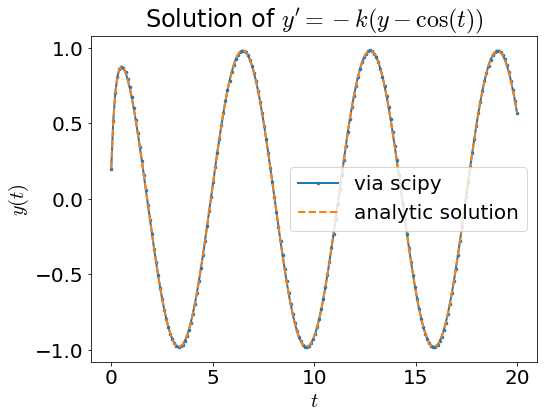

In [3]:
k  = 5 # a parameter
f  = lambda t,y: -k*( y - cos(t) )
y0 = .2;

# We have a known true solution
#   see https://github.com/cu-numcomp/numcomp-class/blob/master/DifferentialEquations.ipynb
y_true = lambda t : (y0 - k**2/(k**2+1) )*exp(-k*t) + k*(sin(t) + k*cos(t))/(k**2+1)


tspan = [0.0,20.0];

sol = solve_ivp(f,tspan,[y0],dense_output=True)
print("t shape:",sol.t.shape)
print("y shape:",sol.y.shape)

y_interpolated = sol.sol # a function!
t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points)[0],".-",MarkerSize=5,label='via scipy')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

## Get RK4 working, as we'll need it
Since multistep methods don't work until we've built up enough history

We'll use the class [RK4](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#The_Runge%E2%80%93Kutta_method)

In [4]:
def OneStepOfRK4(f,t,w,h):
  k1 = h*f(t,     w)
  k2 = h*f(t+h/2, w+k1/2)
  k3 = h*f(t+h/2, w+k2/2)
  k4 = h*f(t+h,   w+k3)
  return w + (k1+2*(k2+k3)+k4)/6

def RK4( f, tspan, y0, h=0.1, n=None, dense_output=False):
  if n == None:
    n = int( (tspan[1] - tspan[0])/h )+1
  t, h = np.linspace(tspan[0],tspan[1],num=n,retstep=True)
  w    = np.zeros(n)
  dydt = np.zeros(n)
  w[0] = y0
  dydt[0] = f(t[0],y0)
  for i in range(n-1):
    w[i+1] = OneStepOfRK4(f, t[i], w[i], h)
    dydt[i+1] = f(t[i+1],w[i+1])
  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(t,w,dydt)
    return t, w, sol
  else:  
    return t, w

and to check if it's working, we'll see if the error converges like $O(h^4)$

In [13]:
hList = np.logspace(-1,-4,10)
t  = np.linspace(tspan[0],tspan[1],1000)
errorList = []
for h in hList:
  tHist, wHist, y_interpolated = RK4( f, tspan, y0, h=h,dense_output=True)
  err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
  errorList.append( err )

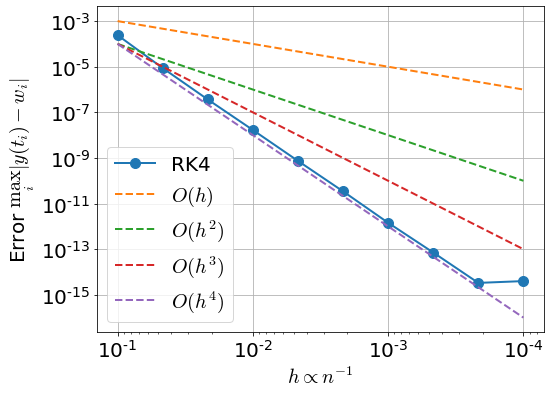

In [14]:
plt.loglog(hList, errorList,"o-",MarkerSize=10,label='RK4')

plt.loglog(hList, 1e-2*hList,'--',label='$O(h)$');
plt.loglog(hList, 1e-2*hList**2,'--',label='$O(h^2)$');
plt.loglog(hList, 1e-1*hList**3,'--',label='$O(h^3)$');
plt.loglog(hList, 1e0*hList**4,'--',label='$O(h^4)$');
plt.legend();
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.gca().invert_xaxis() # think of it as 1/h
plt.xlabel('$h \propto n^{-1}$');

looks good!

## Start with Adams-Bashforth
These are **explicit** so simpler

In [10]:
def AdamsBashforth( f, tspan, y0, h=0.1, n=None, dense_output=False,steps=4):
  if n == None:
    n = int( (tspan[1] - tspan[0])/h )+1
  t, h = np.linspace(tspan[0],tspan[1],num=n,retstep=True)
  if steps < 1:
    raise ValueError("Need steps >= 1")
  w    = np.zeros(n)
  dydt = np.zeros(n)
  w[0] = y0
  dydt[0] = f(t[0],y0)

  # use RK for the first few steps
  for i in range(steps-1):
    w[i+1] = OneStepOfRK4(f, t[i], w[i], h)
    dydt[i+1] = f(t[i+1],w[i+1])

  # Weights here: https://en.wikipedia.org/wiki/Linear_multistep_method#Adams%E2%80%93Bashforth_methods
  if steps==1:
    weights = [1]  # this is forward Euler
    denominator = 1
  elif steps==2:
    weights = [3, -1]
    denominator = 2
  elif steps==3:
    weights = [23, -16, 5]
    denominator = 12
  elif steps==4:
    weights = [55,-59,37,-9]
    denominator = 24
  elif steps==5:
    weights = [1901,-2774,2616,-1274,251]
    denominator = 720
  else:
    raise ValueError("steps should be 1, 2, 3, 4 or 5")
  weights = np.flip( np.array(weights) ) # need to flip order to match

  # The main loop:
  for i in range(steps-1,n-1):
    w[i+1]    = w[i] + h/denominator*np.dot(weights,dydt[i-steps+1:i+1])
    dydt[i+1] = f(t[i+1],w[i+1])

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(t,w,dydt)
    return t, w, sol
  else:  
    return t, w

The following `%debug` will let you see the errors in the previous error!  Very neat

In [ ]:
# see https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=zKNv5g-fFIo4
#%debug

Now, run for different stepsizes $h$ to make sure it converges at the right order

In [15]:
hList = np.logspace(-1,-4,10)
t  = np.linspace(tspan[0],tspan[1],1000)
ListOfMethods = [1,2,3,4,5]
Results = {}
for method in ListOfMethods:
  errorList = []
  for h in hList:
    tHist, wHist, y_interpolated = AdamsBashforth( f, tspan, y0, h=h,dense_output=True, steps=method)
    err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
    errorList.append( err )
  Results[method] = errorList

Make the plot

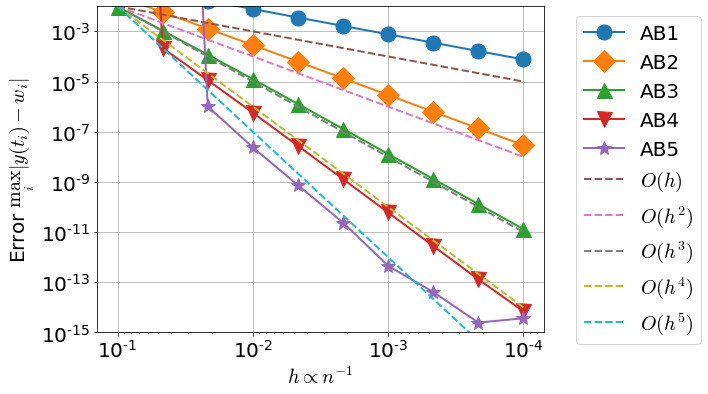

In [16]:
# plt.loglog(1/hList, errorList,".-",MarkerSize=5,label='AdamsBashforth')
import itertools
marker = itertools.cycle(('o', 'D', '^', 'v', '*','s')) # https://stackoverflow.com/a/13092467
# list of markers: https://matplotlib.org/api/markers_api.html

for method in ListOfMethods:
  name = f'AB{method}'
  plt.loglog(hList, Results[method],".-",Marker=next(marker), MarkerSize=15,label=name);

scaling = 10
plt.loglog(hList, scaling*1e-2*hList,'--',label='$O(h)$');
plt.loglog(hList, scaling*1e-1*hList**2,'--',label='$O(h^2)$');
plt.loglog(hList, scaling*1e0*hList**3,'--',label='$O(h^3)$');
plt.loglog(hList, scaling*1e1*hList**4,'--',label='$O(h^4)$');
plt.loglog(hList, scaling*1e2*hList**5,'--',label='$O(h^5)$');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.gca().invert_xaxis() # think of it as 1/h
plt.xlabel('$h \propto n^{-1}$');
plt.ylim(top=1e-2,bottom=1e-15)
# plt.ylim(bottom=1e-15)
plt.show()

(Almost) everything looked good -- the AB5 method isn't quite $O(h^5)$, but this actually makes sense, since we initialized it with RK4, and RK4 is only $O(h^4)$, so if we start it off with extra error, we can't expect it to recover

But now let's look at what happens when $h$ is very large. This is the same plot as above, but allowing the y-scale to be larger:

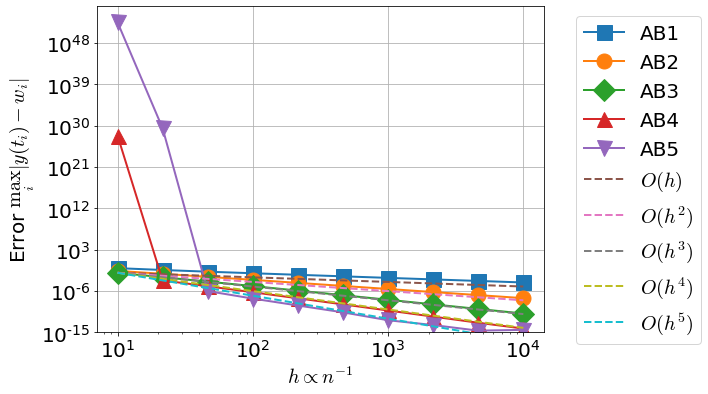

In [17]:
for method in ListOfMethods:
  name = f'AB{method}'
  plt.loglog(1/hList, Results[method],".-",Marker=next(marker), MarkerSize=15,label=name);

scaling = 10
plt.loglog(1/hList, scaling*1e-2*hList,'--',label='$O(h)$');
plt.loglog(1/hList, scaling*1e-1*hList**2,'--',label='$O(h^2)$');
plt.loglog(1/hList, scaling*1e0*hList**3,'--',label='$O(h^3)$');
plt.loglog(1/hList, scaling*1e1*hList**4,'--',label='$O(h^4)$');
plt.loglog(1/hList, scaling*1e2*hList**5,'--',label='$O(h^5)$');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.gca().invert_xaxis() # think of it as 1/h
plt.gca().invert_xaxis() # think of it as 1/h
plt.xlabel('$h \propto n^{-1}$');
# plt.ylim(top=1e-2,bottom=1e-15)
plt.ylim(bottom=1e-15)
plt.show()

What happened? This is an issue with **stability** and we'll talk about it soon.

## Adams-Moulton and Backward Differentiation are Implicit Methods

Since this opens a new issue, let's start with a simple one, **backward Euler**

We need to solve
$$w = \tilde w_{i} + hf(t_{i+1},w)$$
for $w$ (and this will be $w_{i+1}$). Here, $\tilde w_i$ is just $w_i$, but for the othe Adams-Moulton methods, it will be $w_i + hf_i + \ldots$.

We can convert this to a root-finding problem and use Newton's method (then the user must specify the **Jacobian**, which is $\partial f/\partial w$), or we could solve via **fixed-point iterations** which should converge if $h$ is small enough.

Or, we might be lucky, and we can solve for it in closed form.  We're using
$$f(t,y) = -k (y-\cos(t))$$
so we want to solve
$$w = \tilde w_{i} + h(-k (w-\cos(t_i)))$$
and we're in luck, since this is easy to solve:
$$ (1+hk)w = \tilde w_i + hk\cos(t_i)$$
so
$$w = \frac{\tilde w_i + hk\cos(t_i)}{1+hk}$$

So for now, let's avoid the Newton method or fixed-point approach, and require that the user supplies a function `invF` which computes
$$w = F^{-1}(\tilde w_i, h, t )
\quad\implies\quad w = \tilde w_i + hf(t,w)
$$

In [20]:
k  = 5 # a parameter

def f(t,y):
  return -k*( y - cos(t) )

def invF(wTilde,h,t):
  return (wTilde + h*k*cos(t))/(1+h*k)

Now we're ready to define our Adams-Moulton method

In [18]:
def AdamsMoulton( f, tspan, y0, h=0.1, n=None, dense_output=False,steps=4,invF = None):
  if n == None:
    n = int( (tspan[1] - tspan[0])/h )+1
  if invF == None:
    raise ValueError("This is an implicit method, we need invF to be defined")
  t, h = np.linspace(tspan[0],tspan[1],num=n,retstep=True)
  if steps < 0:
    raise ValueError("Need steps >= 0")
  w    = np.zeros(n)
  dydt = np.zeros(n)
  w[0] = y0
  dydt[0] = f(t[0],y0)

  # use RK for the first few steps
  for i in range(steps-1):
    w[i+1] = OneStepOfRK4(f, t[i], w[i], h)
    dydt[i+1] = f(t[i+1],w[i+1])

  # Weights here: https://en.wikipedia.org/wiki/Linear_multistep_method#Adams%E2%80%93Moulton_methods
  if steps==0:
    weights = []  # this is backward Euler
    bm = 1
    denominator = 1
  elif steps==1:
    weights = [1]
    bm = 1
    denominator = 2
  elif steps==2:
    weights = [8,-1]
    bm = 5
    denominator = 12
  elif steps==3:
    weights = [19,-5,1]
    bm = 9
    denominator = 24
  elif steps==4:
    weights = [646,-264,106,-19]
    bm = 251
    denominator = 720
  else:
    raise ValueError("steps should be 1, 2, 3, 4 or 5")
  weights = np.flip( np.array(weights) ) # need to flip order to match

  # The main loop:
  if steps==0:
    # backward Euler
    for i in range(n-1):
      w[i+1]    = invF(w[i],h,t[i+1])
      dydt[i+1] = f(t[i+1],w[i+1])
  else:
    hbm = h*bm/denominator  # no need to recompute this at every step
    for i in range(steps-1,n-1):
      wTilde    = w[i] + h/denominator*np.dot(weights,dydt[i-steps+1:i+1])
      w[i+1]    = invF(wTilde,hbm,t[i+1])
      dydt[i+1] = f(t[i+1],w[i+1])

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(t,w,dydt)
    return t, w, sol
  else:  
    return t, w

Now let's test out the method. To make sure it's implemented correctly, the best test is to see if it converges with the right order of $h$

In [21]:
hList = np.logspace(-1,-4,10)
t  = np.linspace(tspan[0],tspan[1],1000)
ListOfMethods = [0,1,2,3,4]
Results = {}
for method in ListOfMethods:
  errorList = []
  for h in hList:
    tHist, wHist, y_interpolated = AdamsMoulton( f, tspan, y0, h=h,dense_output=True, steps=method,invF = invF)
    err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
    errorList.append( err )
  Results[method] = errorList

Plot the results

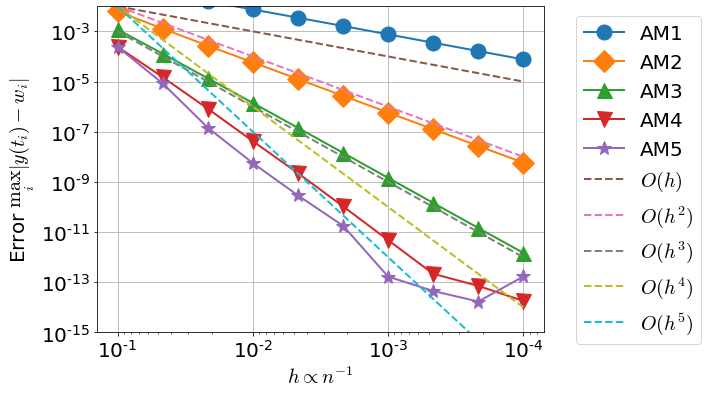

In [24]:
import itertools
marker = itertools.cycle(('o', 'D', '^', 'v', '*','s')) # https://stackoverflow.com/a/13092467
# list of markers: https://matplotlib.org/api/markers_api.html

for method in ListOfMethods:
  name = f'AM{method+1}'
  plt.loglog(hList, Results[method],".-",Marker=next(marker), MarkerSize=15,label=name);

scaling = 10
plt.loglog(hList, scaling*1e-2*hList,'--',label='$O(h)$');
plt.loglog(hList, scaling*1e-1*hList**2,'--',label='$O(h^2)$');
plt.loglog(hList, scaling*1e-1*hList**3,'--',label='$O(h^3)$');
plt.loglog(hList, scaling*1e1*hList**4,'--',label='$O(h^4)$');
plt.loglog(hList, scaling*1e2*hList**5,'--',label='$O(h^5)$');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.gca().invert_xaxis() # think of it as 1/h
plt.xlabel('$h \propto n^{-1}$');
plt.ylim(top=1e-2,bottom=1e-15)
plt.show()

Note that, unlike Adams-Bashforth, we now don't have any huge errors for large $g$. Implicit methods have different stability properties than explicit methods, which we'll talk about shortly